# **Import**

In [3]:
!pip install farasa
!pip install arabic-stopwords
!pip install nlpaug
!pip install tashaphyne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 4.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import tashaphyne.arabic_const as arab_const
import tashaphyne.normalize as normalizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, LSTM, Embedding, MaxPooling1D, Bidirectional, Input
from tensorflow.keras.models import Model

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
import time
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score


nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **DATA**

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"osamashaaban","key":"eea85bd52427e491c25244e7ddddd718"}'}

In [6]:
!pip install -q kaggle

In [7]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# List available datasets.
!kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
alphiree/cardiovascular-diseases-risk-prediction-dataset        Cardiovascular Diseases Risk Prediction Dataset       5MB  2023-07-03 12:12:19           5207        214  1.0              
nelgiriyewithana/countries-of-the-world-2023                    Global Country Information Dataset 2023              23KB  2023-07-08 20:37:33           3985        147  1.0              
arnavsmayan/netflix-userbase-dataset                            Netflix Userbase Dataset                             25KB  2023-07-04 07:38:41           5175        104  1.0              
byomokeshsenapati/spotify-song-attributes                   

In [9]:
# Copy the stackoverflow data set locally.
!kaggle datasets download -d tariqmassaoudi/hespress

 85% 57.0M/67.2M [00:00<00:00, 96.0MB/s]
100% 67.2M/67.2M [00:00<00:00, 99.9MB/s]


In [10]:
# Unzip the downloaded dataset
import zipfile

# Replace 'dataset_name.zip' with the name of the downloaded zip file
with zipfile.ZipFile('hespress.zip', 'r') as zip_ref:
    zip_ref.extractall('.')


In [19]:
# List all the CSV files in the Colab notebook directory
csv_files = [file for file in os.listdir('.') if file.startswith('stories')]

In [20]:
csv_files

['stories_politique.csv',
 'stories_medias.csv',
 'stories_regions.csv',
 'stories_sport.csv',
 'stories_marocains-du-monde.csv',
 'stories_economie.csv',
 'stories_orbites.csv',
 'stories_faits-divers.csv',
 'stories_art-et-culture.csv',
 'stories_tamazight.csv',
 'stories_societe.csv']

In [23]:
# Initialize an empty list to store DataFrames from each CSV file
dataframes = []

# Loop through each CSV file, read it, and append it to the list
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Combine all the DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

In [24]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  11000 non-null  int64 
 1   id          11000 non-null  object
 2   title       11000 non-null  object
 3   date        11000 non-null  object
 4   author      11000 non-null  object
 5   story       11000 non-null  object
 6   topic       11000 non-null  object
dtypes: int64(1), object(6)
memory usage: 601.7+ KB


In [25]:
data = combined_df.loc[:,['story','topic']]
data.sample(20)

,story,topic
1752,تجاهلت جميع وسائل الإعلام القطرية العديد من ال...,medias
6958,يُتابع المغاربة عن كثب التطورات المتسارعة بين ...,orbites
10689,سجّلت السلطات المحلية والمصالح الصحية بإقليم خ...,societe
6697,"قرّبت جائحة ""كورونا"" بين أتباعِ الدّيانات السم...",orbites
8088,سبق أن قدمت لقراء هسبريس صديقي المستشرق الألما...,art-et-culture
5668,أحصت نادية فتاح العلوي، وزيرة السياحة والنقل ا...,economie
9129,بعد مرور شهرين ونصف على المصادقة على القانون ا...,tamazight
478,أعطى رئيس الحكومة، سعد الدين العثماني، تعليمات...,politique
9048,عادات عديدة تزخر بها المناطق السوسية شكلت وما ...,tamazight
5880,وافقت لجنة اليقظة الاقتصادية، المحدثة من قبل ا...,economie


# EDA

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   story   11000 non-null  object
 1   topic   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [27]:
# Drop duplicates from the DataFrame based on the 'story' and 'topic' columns
data.drop_duplicates(subset=['story', 'topic'], keep='first', inplace=True)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10996 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   story   10996 non-null  object
 1   topic   10996 non-null  object
dtypes: object(2)
memory usage: 257.7+ KB


Number of values per class : 
medias                1000
sport                 1000
marocains-du-monde    1000
faits-divers          1000
art-et-culture        1000
tamazight             1000
societe               1000
politique              999
regions                999
economie               999
orbites                999
Name: topic, dtype: int64


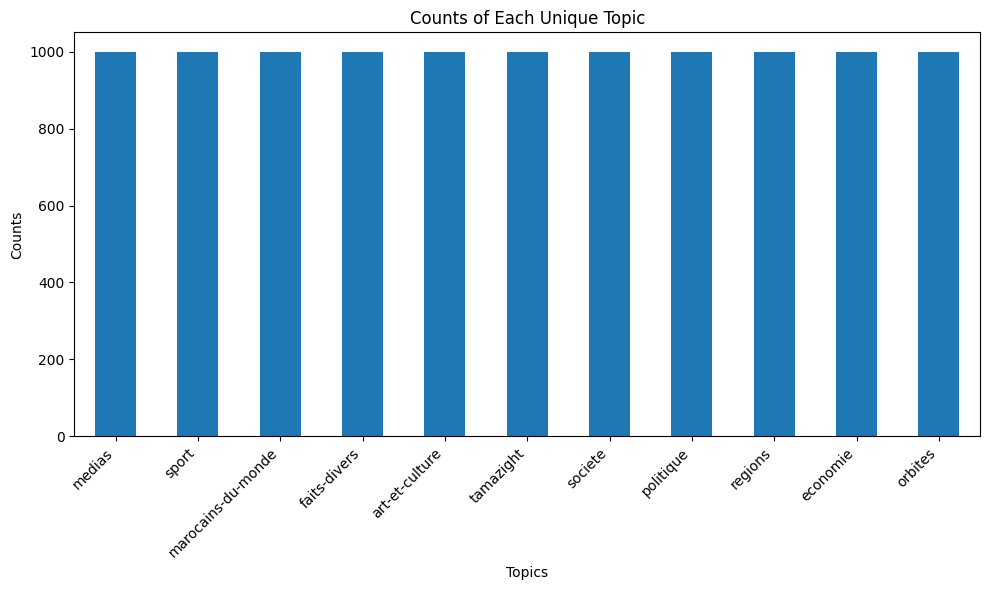

In [36]:
# Count the occurrences of each unique value in the 'topic' column
topic_counts = data['topic'].value_counts()
print(f"Number of values per class : \n{topic_counts}")
# Plot the counts in a bar graph
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.xlabel('Topics')
plt.ylabel('Counts')
plt.title('Counts of Each Unique Topic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Counts_of_classes.png')
plt.show()


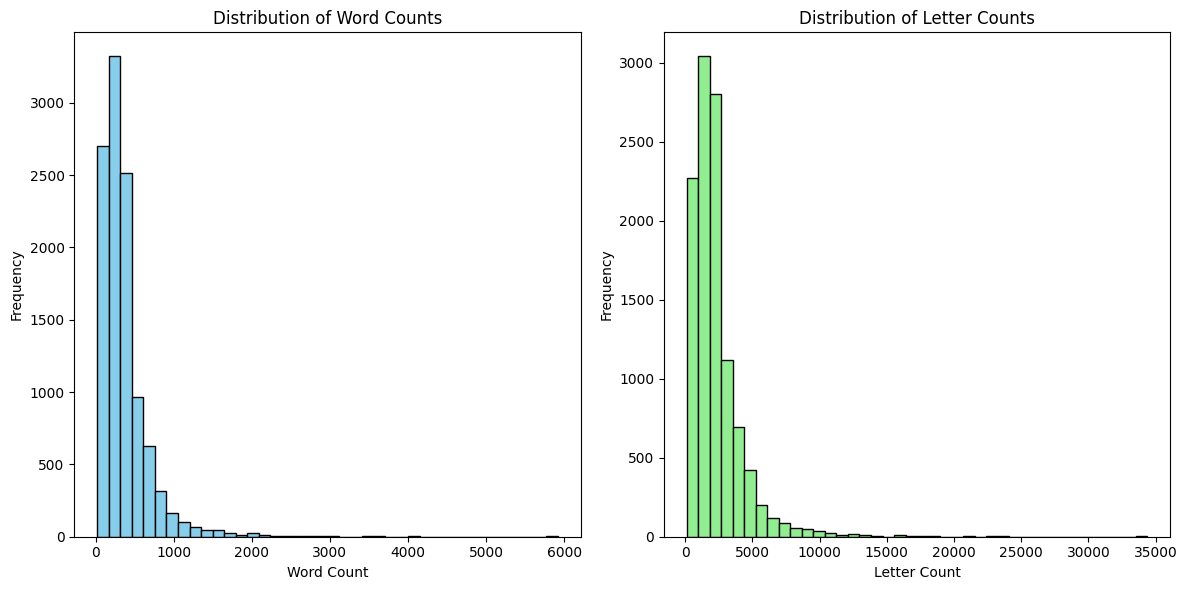

In [35]:
# Calculate the length of each example in terms of words
word_counts = data['story'].apply(lambda x: len(str(x).split()))

# Calculate the length of each example in terms of letters (characters)
letter_counts = data['story'].apply(lambda x: len(str(x)))

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for word count
plt.subplot(1, 2, 1)
plt.hist(word_counts, bins=40, color='skyblue', edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')

# Histogram for letter count
plt.subplot(1, 2, 2)
plt.hist(letter_counts, bins=40, color='lightgreen', edgecolor='black')
plt.xlabel('Letter Count')
plt.ylabel('Frequency')
plt.title('Distribution of Letter Counts')

plt.tight_layout()
plt.savefig('word_letter_counts_histogram.png')
plt.show()


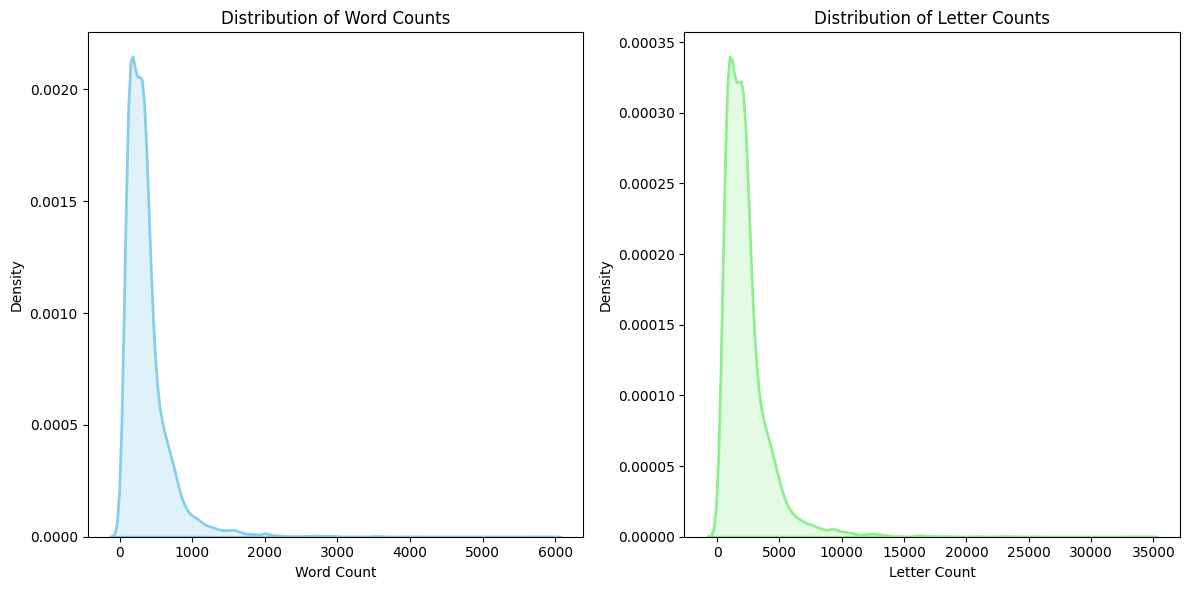

In [37]:
# Calculate the length of each example in terms of words and save in a variable
word_counts = data['story'].apply(lambda x: len(str(x).split()))

# Calculate the length of each example in terms of letters (characters) and save in a variable
letter_counts = data['story'].apply(lambda x: len(str(x)))

# Plot KDE plots
plt.figure(figsize=(12, 6))

# KDE plot for word count
plt.subplot(1, 2, 1)
sns.kdeplot(data=word_counts, fill=True, color='skyblue', linewidth=2)
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.title('Distribution of Word Counts')

# KDE plot for letter count
plt.subplot(1, 2, 2)
sns.kdeplot(data=letter_counts, fill=True, color='lightgreen', linewidth=2)
plt.xlabel('Letter Count')
plt.ylabel('Density')
plt.title('Distribution of Letter Counts')

plt.tight_layout()
plt.savefig('word_letter_counts_distribution.png')
plt.show()


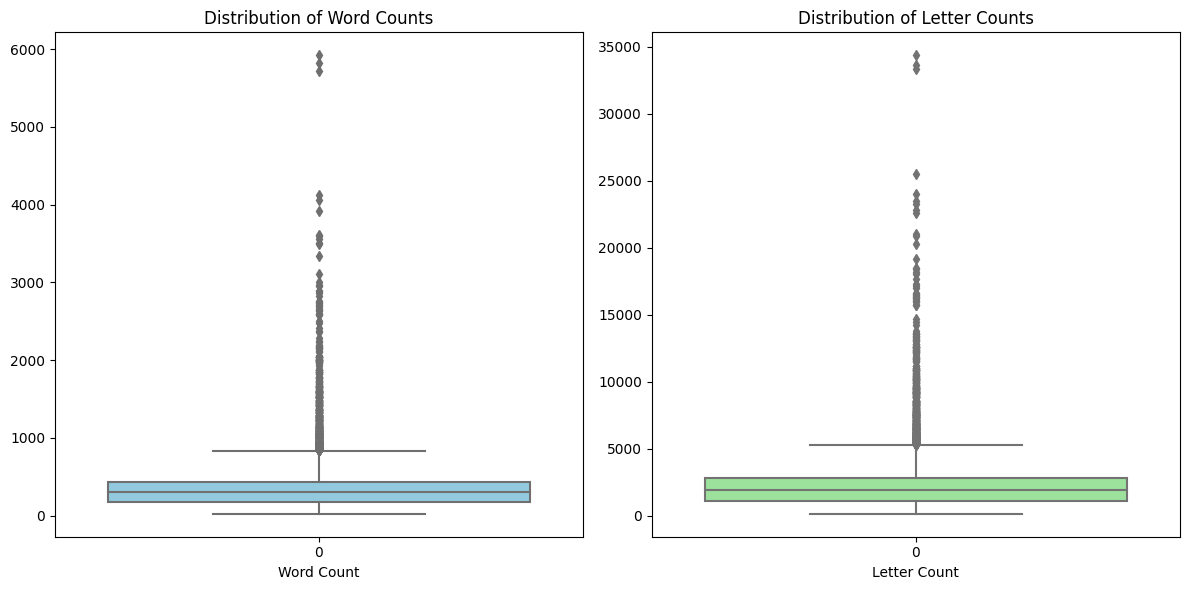

In [38]:
# Calculate the length of each example in terms of words and save in a variable
word_counts = data['story'].apply(lambda x: len(str(x).split()))

# Calculate the length of each example in terms of letters (characters) and save in a variable
letter_counts = data['story'].apply(lambda x: len(str(x)))

# Plot box plots
plt.figure(figsize=(12, 6))

# Box plot for word count
plt.subplot(1, 2, 1)
sns.boxplot(data=word_counts, color='skyblue')
plt.xlabel('Word Count')
plt.title('Distribution of Word Counts')

# Box plot for letter count
plt.subplot(1, 2, 2)
sns.boxplot(data=letter_counts, color='lightgreen')
plt.xlabel('Letter Count')
plt.title('Distribution of Letter Counts')

plt.tight_layout()
plt.savefig('word_letter_counts_boxplot.png')
plt.show()


In [34]:
# Summary statistics for word counts
word_counts_median = word_counts.median()
word_counts_q1 = word_counts.quantile(0.25)
word_counts_q3 = word_counts.quantile(0.75)
word_counts_iqr = word_counts_q3 - word_counts_q1
word_counts_lower_whisker = word_counts_q1 - 1.5 * word_counts_iqr
word_counts_upper_whisker = word_counts_q3 + 1.5 * word_counts_iqr

# Summary statistics for letter counts
letter_counts_median = letter_counts.median()
letter_counts_q1 = letter_counts.quantile(0.25)
letter_counts_q3 = letter_counts.quantile(0.75)
letter_counts_iqr = letter_counts_q3 - letter_counts_q1
letter_counts_lower_whisker = letter_counts_q1 - 1.5 * letter_counts_iqr
letter_counts_upper_whisker = letter_counts_q3 + 1.5 * letter_counts_iqr

# Print the summary statistics
print("Summary Statistics for Word Counts:")
print("Median:", word_counts_median)
print("Q1:", word_counts_q1)
print("Q3:", word_counts_q3)
print("IQR:", word_counts_iqr)
print("Lower Whisker:", word_counts_lower_whisker)
print("Upper Whisker:", word_counts_upper_whisker)

print("\nSummary Statistics for Letter Counts:")
print("Median:", letter_counts_median)
print("Q1:", letter_counts_q1)
print("Q3:", letter_counts_q3)
print("IQR:", letter_counts_iqr)
print("Lower Whisker:", letter_counts_lower_whisker)
print("Upper Whisker:", letter_counts_upper_whisker)


Summary Statistics for Word Counts:
Median: 298.0
Q1: 173.0
Q3: 439.0
IQR: 266.0
Lower Whisker: -226.0
Upper Whisker: 838.0

Summary Statistics for Letter Counts:
Median: 1889.0
Q1: 1101.0
Q3: 2780.0
IQR: 1679.0
Lower Whisker: -1417.5
Upper Whisker: 5298.5


# Preprocessing

In [42]:
# Define a list of common Arabic stopwords
arabic_stopwords = ["و", "في", "على", "من", "إلى", "أن", "هذا", "ذلك", "كان", "عن", "مع", "لكن", "ما", "هل", "هم", "هن", "أو", "إذا", "مع", "أنت", "أنا", "نحن", "أنتم", "إياكم", "هو", "هي", "كل", "جميع", "ذلك", "هناك", "هنالك", "هاتان", "هاتين", "هؤلاء", "أولئك"]

# Normalize Arabic text using NLTK and Tashaphyne
def normalize_arabic_text(text):
    # Remove diacritics
    text = normalizer.normalize_hamza(text)
    text = normalizer.normalize_lamalef(text)
    text = normalizer.normalize_searchtext(text)
    text = normalizer.normalize_spellerrors(text)

    # Remove any URLs from the text
    text = re.sub(r'http\S+', '', text)

    # Remove any special characters and punctuations
    text = re.sub('[^\w\s]', '', text)

    # Convert the text to lowercase
    text = text.lower()

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word not in arabic_stopwords]

    # Perform stemming using the Snowball stemmer for Arabic
    stemmer = SnowballStemmer('arabic')
    words = [stemmer.stem(word) for word in words]

    # Join the words back to form the cleaned text
    cleaned_text = ' '.join(words)

    return cleaned_text

# Apply the normalization function to the 'story' column and save the result in 'clean_story' column
data['clean_story'] = data['story'].apply(normalize_arabic_text)


In [43]:
data.sample(20)

,story,topic,clean_story
877,أكد محمد بشير الراشدي، رئيس الهيئة الوطنية للن...,politique,اكد محمد شير راشد رءيس هيءه وطنيه نزاهه والوق ...
7547,فتحت المصلحة الولائية للشرطة القضائية بمدينة ف...,faits-divers,فتح مصلحه ولاءيه شرطه قضاءيه بمد فاس بحث قضاء ...
7144,تمكنت عناصر الدرك الملكي بالمركز الترابي حد بو...,faits-divers,تمكن عناصر درك ملك مركز تراب حد وموس تنسيق قيا...
5594,لم يُسفر اللقاء الذي عقده سعد الدين العثماني، ...,economie,لم يسفر لقاء الذ عقد سعد دين عثمان رءيس حكومه ...
10112,تعرف عدد من الصيدليات عبر مختلف ربوع المملكة ا...,societe,تعرف عدد صيدل عبر مختلف ربوع مملكه اختفاء اقرا...
8101,بحثا في الإرث الذي تركه الأكاديميّ عبد الكبير ...,art-et-culture,بحث ارث الذ ترك اكاديم عبد كبير خطيب انثروبولو...
4560,على الرغم من أن لا أحد يُجادل في دور مغاربة ال...,marocains-du-monde,عل رغم ان لا احد يجادل دور مغارب عالم منظوم مغ...
2127,قرّرت المديرية الإقليمية لوزارة التربية الوطني...,regions,قرر مديريه اقليميه وزار تربيه وطنيه ناظور عوده...
6653,يجمع مختلف الباحثين والسياسيين على أن جائحة في...,orbites,يجمع مختلف باحث سياس عل ان جاءح يروس كور مستجد...
3976,أعلنت الجامعة الملكية المغربية لكرة القدم عن ق...,sport,اعلن جامعه ملكيه مغربيه لكر قدم قرار اجراء مبا...


In [45]:
# Define the number of top n-grams you want to find
top_ngrams_count = 10

# Prepare the data
sentences = data['story'].tolist()
labels = data['topic'].tolist()

# Initialize TfidfVectorizer with the desired n-gram range (1 for unigrams, 2 for bigrams, etc.)
ngram_range = (5,5)  # You can adjust this to find different n-grams
tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, analyzer='word')

# Fit and transform the sentences to get the TF-IDF scores
sentence_tfidf = tfidf_vectorizer.fit_transform(sentences)

# Convert the TF-IDF scores to a DataFrame
tfidf_df = pd.DataFrame(sentence_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate the 'topic' column to the TF-IDF DataFrame
tfidf_df['topic'] = labels

# Group by class and calculate the average TF-IDF scores for each n-gram
tfidf_scores = tfidf_df.groupby('topic').mean()

# Get the top frequent n-grams for each class and overall
top_ngrams_overall = tfidf_scores.mean().nlargest(top_ngrams_count)
top_ngrams_per_class = {topic: tfidf_scores.loc[topic].nlargest(top_ngrams_count) for topic in tfidf_scores.index}

# Print the results
print("Top {} Frequent N-grams Overall:".format(top_ngrams_count))
print(top_ngrams_overall)

print("\nTop {} Frequent N-grams Per Class:".format(top_ngrams_count))
for topic, top_ngrams in top_ngrams_per_class.items():
    print("Topic:", topic)
    print(top_ngrams)
    print("\n")


Top 10 Frequent N-grams Overall:
في تصريح لجريدة هسبريس الإلكترونية               0.001195
تحت إشراف النيابة العامة المختصة                 0.000897
تصريح لجريدة هسبريس الإلكترونية أن               0.000877
الحراسة النظرية رهن إشارة البحث                  0.000811
الشؤون الخارجية والتعاون الإفريقي والمغاربة      0.000694
الخارجية والتعاون الإفريقي والمغاربة المقيمين    0.000694
تحت تدبير الحراسة النظرية رهن                    0.000681
تدبير الحراسة النظرية رهن إشارة                  0.000675
والتعاون الإفريقي والمغاربة المقيمين بالخارج     0.000667
بفيروس كورونا المستجد خلال الـ24                 0.000648
dtype: float64

Top 10 Frequent N-grams Per Class:
Topic: art-et-culture
محمد السادس للفن الحديث والمعاصر              0.001356
في تصريح لجريدة هسبريس الإلكترونية            0.001049
أكاديمية المملكة المغربية للتعاون الثقافي     0.000930
الثقافة والشباب والرياضة قطاع الثقافة         0.000904
النقابة المغربية لمهنيي الفنون الدرامية       0.000862
مؤسسة أكاديمية المملكة المغربية للتعاون

# Data Reconstruction

In [49]:
data['topic'].unique()

'politique'

In [54]:
data["labels"] = data["topic"]
count = 0.
labels_map = {}
# Mapping evert class name to a specific number
for i in data['topic'].unique():
  data["labels"] = data["labels"].replace([i],[count])
  labels_map[count] = i
  count += 1



In [55]:
data["labels"].sample(20)

2016      2.0
5476      5.0
2826      2.0
3849      3.0
1309      1.0
10827    10.0
6480      6.0
2454      2.0
4026      4.0
8681      8.0
10015    10.0
8077      8.0
6610      6.0
10196    10.0
3538      3.0
10411    10.0
3133      3.0
5410      5.0
9581      9.0
5969      5.0
Name: labels, dtype: float64

In [56]:
labels_map

{0.0: 'politique',
 1.0: 'medias',
 2.0: 'regions',
 3.0: 'sport',
 4.0: 'marocains-du-monde',
 5.0: 'economie',
 6.0: 'orbites',
 7.0: 'faits-divers',
 8.0: 'art-et-culture',
 9.0: 'tamazight',
 10.0: 'societe'}

In [60]:
# Shuffle the DataFrame
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_data.tail(40)
# frac=1 means we want to sample the entire DataFrame (all rows).
# random_state=42 ensures reproducibility of the shuffling. You can choose any integer value.
# The reset_index(drop=True) will reset the index of the shuffled DataFrame so that it starts from 0.

,story,topic,clean_story,labels
10956,اتخذت إدارة فريق حسنية أكادير لكرة القدم العدي...,sport,اتخذ ادار ريق حسن اكادير لكر قدم عديد قرار احت...,3.0
10957,خطف المغربي رضا خرشوش، مهاجم نادي تيلستار الهو...,sport,خطف مغرب رضا خرشوش مهاجم ناد تيلستار هولند لكر...,3.0
10958,مطالعة أنباء بعض الورقيات الصادرة يوم الخميس م...,medias,مطالع انباء بعض ورق صادره يوم خميس احداث مغربي...,1.0
10959,بمناسبة اليوم العالمي لحرية الصحافة، الذي يحتف...,medias,مناسب يوم عالم لحر صحافه الذ يحتفل به عالم يوم...,1.0
10960,تمكنت الشرطة القضائية بخريبكة، بتعليمات من الن...,faits-divers,تمكن شرطه قضاءيه خريب تعليم نيابه عامه محكمه ا...,7.0
10961,يتداول عدد من البرلمانيين بمجلس النواب إمكانية...,medias,يتداول عدد برلمان مجلس نواب امكان تشكيل لجن لت...,1.0
10962,على الرغم من البعد عن الوطن الأم، يتشبث أفراد ...,marocains-du-monde,عل رغم بعد وطن الام يتشبث افراد جاليه مغربيه م...,4.0
10963,تحدث وحيد خاليلوزيتش، مدرب المنتخب المغربي الأ...,sport,تحدث حيد خاليلوزيتش مدرب منتخب مغرب اول لكر قد...,3.0
10964,أفادت المديرية العامة للأرصاد الجوية بأنه من ا...,regions,افاد مديريه عامه ارصاد جويه بان مرتقب ان تهم ز...,2.0
10965,بالتزامن مع تقديم الأحزاب السياسية لمذكراتها ح...,politique,تزام تقديم احزاب سياسيه مذكر حول انتخاب تجدد ن...,0.0


# **Modeling**

In [153]:
# Split the data into training (60%), validation (20%), and testing (20%) sets
train_data, temp_data = train_test_split(shuffled_data, test_size=0.4, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [154]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['clean_story'])

# Convert text data to sequences
X_train = tokenizer.texts_to_sequences(train_data['clean_story'])
X_valid = tokenizer.texts_to_sequences(valid_data['clean_story'])
X_test = tokenizer.texts_to_sequences(test_data['clean_story'])

# Pad sequences to have the same length
max_sequence_length = 1000  # Set the maximum sequence length as needed
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_valid = pad_sequences(X_valid, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

# Encode class labels as numerical values
num_classes = len(shuffled_data['topic'].unique())
y_train = np_utils.to_categorical(train_data['labels'], num_classes)
y_valid = np_utils.to_categorical(valid_data['labels'], num_classes)
y_test = np_utils.to_categorical(test_data['labels'], num_classes)


In [157]:
# Define the model
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 1000, 100)         9459200   
                                                                 
 conv1d_22 (Conv1D)          (None, 996, 128)          64128     
                                                                 
 conv1d_23 (Conv1D)          (None, 992, 128)          82048     
                                                                 
 global_max_pooling1d_15 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_44 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                     

In [158]:
# Train the model
batch_size = 64
epochs = 10

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/10
104/104 [==============================] - 23s 210ms/step - loss: 2.2050 - accuracy: 0.2174 - val_loss: 1.6351 - val_accuracy: 0.4729
Epoch 2/10
104/104 [==============================] - 22s 208ms/step - loss: 1.2619 - accuracy: 0.5821 - val_loss: 0.8585 - val_accuracy: 0.7462
Epoch 3/10
104/104 [==============================] - 22s 210ms/step - loss: 0.7162 - accuracy: 0.7793 - val_loss: 0.7336 - val_accuracy: 0.7785
Epoch 4/10
104/104 [==============================] - 22s 209ms/step - loss: 0.4083 - accuracy: 0.8763 - val_loss: 0.7721 - val_accuracy: 0.7776
Epoch 5/10
104/104 [==============================] - 22s 210ms/step - loss: 0.2252 - accuracy: 0.9341 - val_loss: 0.8758 - val_accuracy: 0.7867
Epoch 6/10
104/104 [==============================] - 22s 210ms/step - loss: 0.1318 - accuracy: 0.9662 - val_loss: 0.9653 - val_accuracy: 0.7840
Epoch 7/10
104/104 [==============================] - 22s 211ms/step - loss: 0.0740 - accuracy: 0.9792 - val_loss: 1.1013 - val_ac

In [159]:
# Get predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
class_report = classification_report(y_true, y_pred_classes)
overall_accuracy = accuracy_score(y_true, y_pred_classes)

print("Classification Report:\n", class_report)
print("Overall Accuracy:", overall_accuracy)

69/69 [==============================] - 1s 14ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.69      0.72       197
           1       0.90      0.90      0.90       212
           2       0.73      0.80      0.76       193
           3       0.97      0.94      0.96       199
           4       0.91      0.71      0.80       202
           5       0.67      0.88      0.76       195
           6       0.59      0.56      0.58       198
           7       0.91      0.88      0.90       216
           8       0.83      0.79      0.81       201
           9       0.89      0.94      0.92       192
          10       0.57      0.60      0.58       195

    accuracy                           0.79      2200
   macro avg       0.79      0.79      0.79      2200
weighted avg       0.80      0.79      0.79      2200

Overall Accuracy: 0.79
